In [742]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [689]:
%matplotlib inline

In [690]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HW1 - Classification models in sklearn

You'll be building a few classifier models and using some of the tech tools we learned about in Modules 1 and 2. 

## The Data

The data is a relatively small and simple dataset of taxpayer data. I got it from:

https://www.kaggle.com/dmaillie/sample-us-taxpayer-dataset

As you'll see if you visit that page, this dataset was used in a series of YouTube tutorials on using R to build random forest models. 

I read it into a pandas dataframe and used `info()` to get:

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HHI             1004 non-null   int64 
 1   HHDL            1004 non-null   int64 
 2   Married         1004 non-null   int64 
 3   CollegGrads     1004 non-null   int64 
 4   AHHAge          1004 non-null   int64 
 5   Cars            1004 non-null   int64 
 6   Filed_2017      1004 non-null   int64 
 7   Filed_2016      1004 non-null   int64 
 8   Filed_2015      1004 non-null   int64 
 9   PoliticalParty  1004 non-null   object
dtypes: int64(9), object(1)
memory usage: 78.6+ KB
```

Some information about the fields:

* `HHI` - household income
* `HHDL` - household debt level
* `Married` - categorical with a few levels
* `CollegGrads` - number of college grads in the household
* `AHHAge` - average age of people in the household
* `Cars` - number of cars in the household
* `Filed_2017` - 1 means they filed a tax return with the IRS for 2017
* `Filed_2016` - 1 means they filed a tax return with the IRS for 2016
* `Filed_2015` - 1 means they filed a tax return with the IRS for 2015
* `PoliticalParty` - categorical with 3 levels

## The Problem

Our overall goal is to build classifier models to predict `PoliticalParty` using the the other variables.

### Reading the raw data

Imported the data from csv file to the dataframe tax_df. Checked the datattype of the variables using the info function.

In [691]:
tax_df = pd.read_csv("./data/raw/TaxInfo.csv")
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HHI             1004 non-null   int64 
 1   HHDL            1004 non-null   int64 
 2   Married         1004 non-null   int64 
 3   CollegGrads     1004 non-null   int64 
 4   AHHAge          1004 non-null   int64 
 5   Cars            1004 non-null   int64 
 6   Filed_2017      1004 non-null   int64 
 7   Filed_2016      1004 non-null   int64 
 8   Filed_2015      1004 non-null   int64 
 9   PoliticalParty  1004 non-null   object
dtypes: int64(9), object(1)
memory usage: 78.6+ KB


## EDA

Used pandas_profiling and sweetviz to implement basic EDA. 

In [692]:
from pandas_profiling import ProfileReport

In [693]:
profile = ProfileReport(tax_df, title = "Pandas Profiling Report")

In [694]:
profile.to_file("output/pandas_profiling_report.html")

In [695]:
import sweetviz

In [696]:
report = sweetviz.analyze(tax_df)

                                             |                                             | [  0%]   00:00 ->…

In [697]:
report.show_html("output/sweetviz_report.html")

Report output/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Summary - 
From the html files generated we understand that our target variable has 3 levels. The data frame has 3 numerical and 7 categorical variables. Categorical variables like Married , collegGrads are tagged as numeric data type and needs to be altered to categorical datatype. There are no missing values in any of the variables. All the columns looks like efficient predictors of the target variable.
From the target variable percentage, we can see that all the three categories are evenly distributed in the data (33% average). Variables like HHI and HHDL have high number of unique values. We can look at creating groups in these columns and check if these can be good predictors of the variables.

## `Datatype Conversion`

Converted required variables to categorical datatype

In [698]:
tax_df["Married"] = tax_df["Married"].astype("category")
tax_df["CollegGrads"] = tax_df["CollegGrads"].astype("category")
tax_df["Cars"] = tax_df["Cars"].astype("category")
tax_df["Filed_2017"] = tax_df["Filed_2017"].astype("category")
tax_df["Filed_2016"] = tax_df["Filed_2016"].astype("category")
tax_df["Filed_2015"] = tax_df["Filed_2015"].astype("category")

### Group columns
From the description of the variables, we understand that HHI and HHDL are variables related to the income and debt of a family. From basic EDA we understand that these values are unique by family, but they cannot be ignored as these income or debt groups can impact the category of the target variable (PoliticalParty). Since most of the values in these columns are unique, grouping was better option than lumping the variables.
Grouped the columns using conditional function and then changed the datatype to category.

In [699]:
tax_df['AgeGroup'] = np.where(tax_df.AHHAge<21, '0-20',np.where(tax_df.AHHAge<41,'21-40',np.where(tax_df.AHHAge<61,'41-60',np.where(tax_df.AHHAge<81,'61-80',np.where(tax_df.AHHAge<101,'81-100', 'Greater than 100')))))
tax_df['AgeGroup'] = pd.Categorical(tax_df['AgeGroup'], ["0-20","21-40", "41-60", "61-80", "81-100", "Greater than 100"])
tax_df['HHIGroup'] = np.where(tax_df.HHI<=50000, '0-50k',np.where(tax_df.HHI<=100000,'50-100k',np.where(tax_df.HHI<=150000,'100-150k',np.where(tax_df.HHI<=200000,'150-200k',np.where(tax_df.HHI<250000,'200-250k',np.where(tax_df.HHI<=300000,'250-300k', 'Greater than 300k'))))))
tax_df['HHIGroup'] = pd.Categorical(tax_df['HHIGroup'], ["0-50k","50-100k", "100-150k", "150-200k", "200-250k", "250-300k", "Greater than 300k"])
tax_df['HHDLGroup'] = np.where(tax_df.HHDL<-800000, '-1M to -0.8M',np.where(tax_df.HHDL<-600000,'-0.8M to -0.6M',np.where(tax_df.HHDL<-400000,'-0.6M to -0.4M',np.where(tax_df.HHDL<-200000,'-0.4M to -0.2M',np.where(tax_df.HHDL<0,'-0.2M to 0',np.where(tax_df.HHDL<200000, '0 to 0.2M',np.where(tax_df.HHDL<400000,'0.2M to 0.4M',np.where(tax_df.HHDL<600000,'0.4M to 0.6M',np.where(tax_df.HHDL<800000,'0.6M to 0.8M',np.where(tax_df.HHDL<1000000,'0.8M to 1M', 'Greater than 1M'))))))))))
tax_df['HHDLGroup'] = pd.Categorical(tax_df['HHDLGroup'], ["-1M to -0.8M","-0.8M to -0.6M", "-0.6M to -0.4M", "-0.4M to -0.2M", "-0.2M to 0", "0 to 0.2M", "0.2M to 0.4M","0.4M to 0.6M","0.6M to 0.8M","0.8M to 1M","Greater than 1M" ])

Once we have grouped the values into different categories, we can check if these groups do have an impact on the target variable.

In [700]:
pd.crosstab(tax_df['AgeGroup'], tax_df['PoliticalParty'], normalize = 'index')

PoliticalParty,Democrat,Independent,Republican
AgeGroup,,,
0-20,0.241379,0.379310,0.379310
21-40,0.330508,0.330508,0.338983
41-60,0.371901,0.322314,0.305785
61-80,0.345679,0.341564,0.312757
81-100,0.283505,0.319588,0.396907
Greater than 100,0.366667,0.416667,0.216667


In [701]:
pd.crosstab(tax_df['HHIGroup'], tax_df['PoliticalParty'], normalize = 'index')

PoliticalParty,Democrat,Independent,Republican
HHIGroup,,,
0-50k,0.415094,0.320755,0.264151
50-100k,0.376812,0.318841,0.304348
100-150k,0.294737,0.357895,0.347368
150-200k,0.323353,0.359281,0.317365
200-250k,0.297143,0.320000,0.382857
250-300k,0.320000,0.331429,0.348571


In [702]:
pd.crosstab(tax_df['HHDLGroup'], tax_df['PoliticalParty'], normalize = 'index')

PoliticalParty,Democrat,Independent,Republican
HHDLGroup,,,
-1M to -0.8M,0.305085,0.406780,0.288136
-0.8M to -0.6M,0.384615,0.241758,0.373626
-0.6M to -0.4M,0.368932,0.281553,0.349515
-0.4M to -0.2M,0.247525,0.475248,0.277228
-0.2M to 0,0.333333,0.281250,0.385417
0 to 0.2M,0.360825,0.319588,0.319588
0.2M to 0.4M,0.333333,0.322222,0.344444
0.4M to 0.6M,0.385417,0.250000,0.364583
0.6M to 0.8M,0.323810,0.342857,0.333333


From the above tables we see that Age, HHI and HHDL does impact the choice of an individual in selecting the political party.
    - People in Age groups 41-60 tend to have Democrats as their Political Part
    - Income Level greater than 200K have more supporters for Republicans
    - Higher debt levels tend to support Independent candidates.

These are some of the observations we see after grouping the categories.

We will now go ahead and remove the columns age, HHI and HHDL, as these columns have many unique values which will not help us in predicting the target variable.

In [703]:
cols_to_drop = ['AHHAge','HHI','HHDL']
cols_to_keep = tax_df.columns.tolist()
cols_to_keep = [c for c in cols_to_keep if c not in cols_to_drop]
cols_to_keep

['Married',
 'CollegGrads',
 'Cars',
 'Filed_2017',
 'Filed_2016',
 'Filed_2015',
 'PoliticalParty',
 'AgeGroup',
 'HHIGroup',
 'HHDLGroup']

Updated the data frame by retaining only the required columns and changing the order of the columns as required.

In [704]:
tax_df = tax_df.loc[:,cols_to_keep]
tax_df.describe()
cols = tax_df.columns.tolist()
cols
tax_df = tax_df[['Married','CollegGrads','Cars','Filed_2017','Filed_2016','Filed_2015','AgeGroup','HHIGroup','HHDLGroup','PoliticalParty']]  

We, now have the final list of columns which we can use to create different models.

### Data Transformation

Imported required libraries to transform data and create different models

In [705]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Divided tax_df into two separate dataframes X and y (input variables and Target) , to use in the models.

In [706]:
X = tax_df.iloc[:, 0:9]
y = tax_df.iloc[:, 9]

Created a list with names of numeric columns and categorical columns

In [707]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

Used `standardScaler` to rescale the numerical variables and `OneHotTransformer` to convert string columns to numerical columns by creating dummy variable columns. In the basedata that I have finalized there are no numerical columns

In [708]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

Used `ColumnTransformer` to combine the two transformers we have used in the above code

In [709]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

### Partitioning the data

We will partition our data(X, y) into test and training sets which we can utilize to train and test our models

In [710]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

## Model 1 - Logistic Regression

### Ridge Regularization

We will first create a Logistic Regression model using penalty as ridge, C as 1 solver as saga.

In [711]:
clf_model_l2 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

Used pipeline function and chained all the above steps of data transformation and classifier model together.

In [712]:
clf_l2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l2)])

#### Fitting and testing the model on the training and test dataset

In [713]:
clf_l2.fit(X_train, y_train)
print(f"Training score-clf_l2: {clf_l2.score(X_train, y_train):.3f}")
print(f"Test score-clf_l2: {clf_l2.score(X_test, y_test):.3f}")

Training score-clf_l2: 0.463
Test score-clf_l2: 0.353


Summary -
From the above score we can see that the model is not very good at predicting the target variable. As expected, the test score is less when compared to the training score.

Now we will try different models by changing the value of `C` to check if we can get a better model which can predict the target variable with higher accuracy. We will repeat the same steps of creating the model and then pipeline it and then fit the model using the training dataset.

In [714]:
clf_model_l2_C01 = LogisticRegression(penalty='l2', C=.01, solver='saga', max_iter=500)

clf_l2_C01 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l2_C01)])

clf_l2_C01.fit(X_train, y_train)

print(f"Training score-clf_l2_C01: {clf_l2_C01.score(X_train, y_train):.3f}")
print(f"Test score-clf_l2_C01: {clf_l2_C01.score(X_test, y_test):.3f}")

Training score-clf_l2_C01: 0.436
Test score-clf_l2_C01: 0.348


We see a dip in performance of the model by changing the value of C from 1 to .01.

Checking for the optimal value of C for penalty as l2

In [715]:
clf_model_cv = LogisticRegressionCV(penalty='l2', Cs=[ 0.1, 1, 10], solver='saga', max_iter=500)

clf_l2_cv = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_cv)])

clf_l2_cv.fit(X_train, y_train)

print(f"Training score-clf_l2_cv: {clf_l2_cv.score(X_train, y_train):.3f}")
print(f"Test score-clf_l2_cv: {clf_l2_cv.score(X_test, y_test):.3f}")

Training score-clf_l2_cv: 0.453
Test score-clf_l2_cv: 0.348


Optimal value for C using l2 penalty is C=1 but scores for c=10 are also pretty similar which indicates higher regularization (low values of C) is not very effective for this model

#### Confusion Matrix - Ridge Regularization

Confusion matrix for train, without normalization
[[129  63  75]
 [ 83 114  69]
 [ 73  76 121]]
Normalized confusion matrix for train
[[0.48314607 0.23595506 0.28089888]
 [0.31203008 0.42857143 0.2593985 ]
 [0.27037037 0.28148148 0.44814815]]


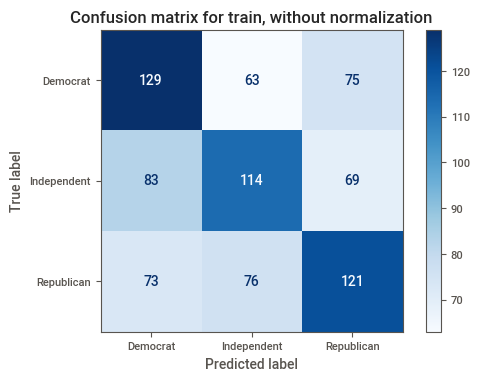

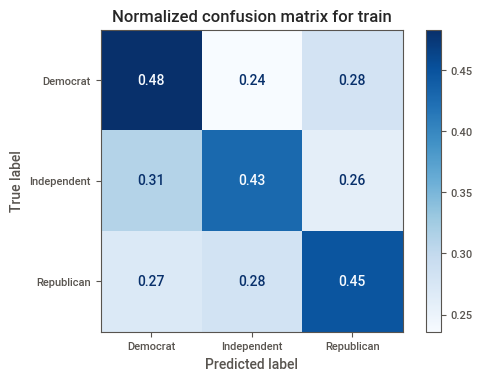

In [716]:
# confusion matrix for training data
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_l2_cv['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l2_cv, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, without normalization
[[26 26 17]
 [24 25 22]
 [20 22 19]]
Normalized confusion matrix for test
[[0.37681159 0.37681159 0.24637681]
 [0.33802817 0.35211268 0.30985915]
 [0.32786885 0.36065574 0.31147541]]


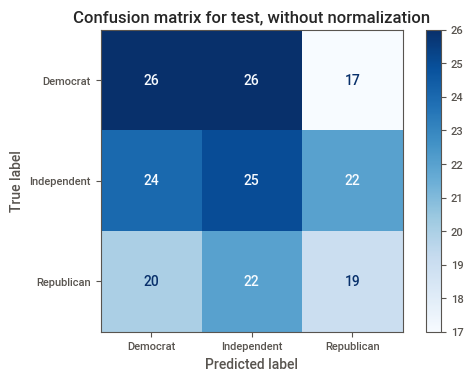

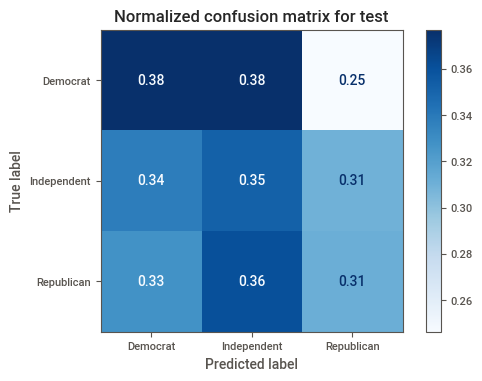

In [740]:
# confusion matrix for test data
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_l2_cv['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l2_cv, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

#### Summary (l2)

From the ridge regression model scores and confusion matrix we can conclude the model is not efficient in predicting the output variable. As expected, test scores have decreased when compared to training score as the model was fitted using the training data. When the model was exposed to newer data it had reduced efficiency. Confusion Matrix displays the number predictions made by the model correctly and incorrectly.

### Lasso Regularization

Now we will try building a model using lasso penalty (penalty = l1) with similar hyperparameter value.

In [718]:
clf_model_l1 = LogisticRegressionCV(penalty='l1', Cs=[0.1, 1, 10], solver='saga', max_iter=500)

clf_l1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l1)])

clf_l1.fit(X_train, y_train)

print(f"Training score-clf_l1: {clf_l1.score(X_train, y_train):.3f}")
print(f"Test score-clf_l1: {clf_l1.score(X_test, y_test):.3f}")

Training score-clf_l1: 0.380
Test score-clf_l1: 0.294


Confusion matrix for train, without normalization
[[152 115   0]
 [113 153   0]
 [134 136   0]]
Normalized confusion matrix for train
[[0.56928839 0.43071161 0.        ]
 [0.42481203 0.57518797 0.        ]
 [0.4962963  0.5037037  0.        ]]


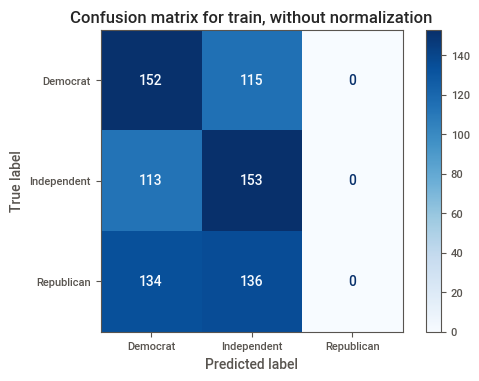

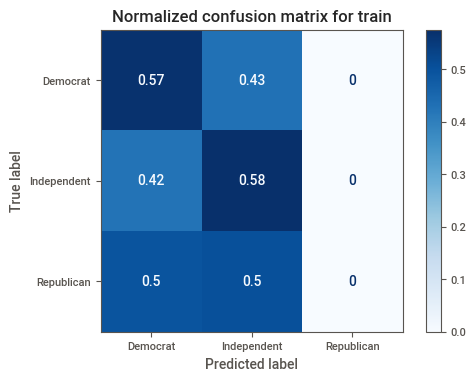

In [719]:
# confusion matrix for training data
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_l1['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l1, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, without normalization
[[25 44  0]
 [37 34  0]
 [31 30  0]]
Normalized confusion matrix for test
[[0.36231884 0.63768116 0.        ]
 [0.52112676 0.47887324 0.        ]
 [0.50819672 0.49180328 0.        ]]


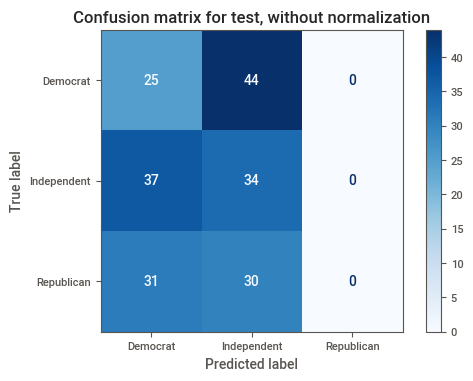

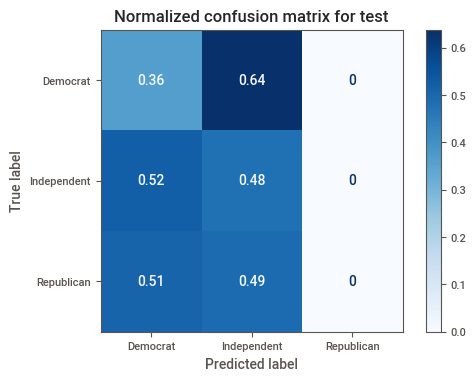

In [720]:
# confusion matrix for test data
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_l1['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l1, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Summary(l1)
Training and test scores for lasso penalty has reduced when compared to ridge, reason can be the model is trying to drive many coefficients to 0. It also seems that the Republican party was the toughest to predict. As expected training score is better when compared to test scores of the model

### Elasticnet Regression

Created third type of model using elasticnet regularization. Added the values of l1 ratios for the model.

In [721]:
clf_model_en = LogisticRegressionCV(penalty='elasticnet', Cs=[ 0.1, 1, 10] ,solver='saga', max_iter=500, l1_ratios=[0.0, 0.25, 0.5, 0.75, 1.0])

clf_en = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_en)])

clf_en.fit(X_train, y_train)

print(f"Training score-clf_en: {clf_en.score(X_train, y_train):.3f}")
print(f"Test score-clf_en: {clf_en.score(X_test, y_test):.3f}")

Training score-clf_en: 0.380
Test score-clf_en: 0.294


Confusion matrix for train, without normalization
[[152 115   0]
 [113 153   0]
 [134 136   0]]
Normalized confusion matrix for train
[[0.56928839 0.43071161 0.        ]
 [0.42481203 0.57518797 0.        ]
 [0.4962963  0.5037037  0.        ]]


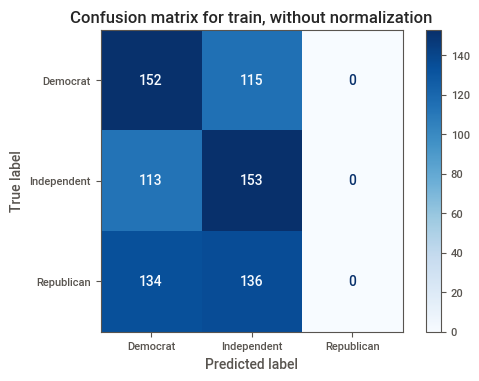

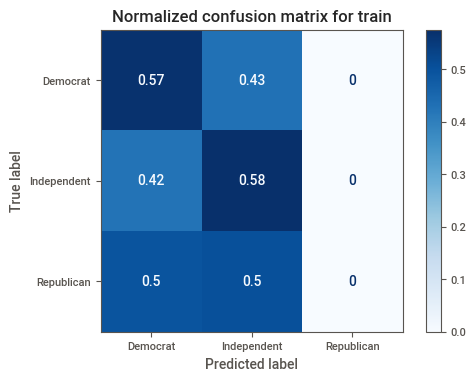

In [722]:
# confusion matrix for training data
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_en['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_en, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for train, without normalization
[[25 44  0]
 [37 34  0]
 [31 30  0]]
Normalized confusion matrix for train
[[0.36231884 0.63768116 0.        ]
 [0.52112676 0.47887324 0.        ]
 [0.50819672 0.49180328 0.        ]]


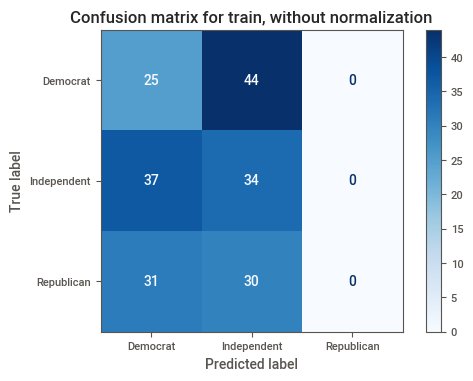

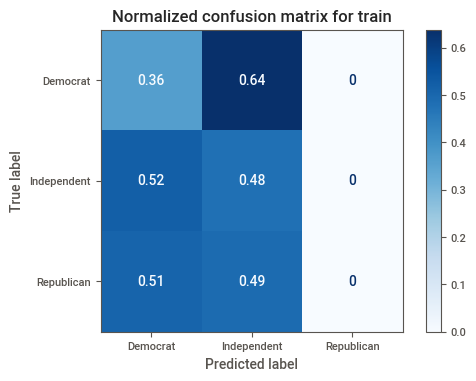

In [723]:
# confusion matrix for test data
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_en['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_en, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

From the scores and confusion matrices above we can conclude that Ridge regularization is doing a better job in predicting the target variable when compared to lasso and Elastic-Net regression. We have got identical results for lasso and Elastic-Net regression models. Observations from both these models are similar.

## Model 2 - Random Forest
Another model that we used was the Random Forest model to predict the target variable. Created new pipeline object for the model and used it to train the model. Trained and tested the model on training and test dataset.

In [724]:
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(oob_score=True, random_state=0))])

clf_rf.fit(X_train, y_train)

print(f"Training score: {clf_rf.score(X_train, y_train):.3f}")
print(f"Test score: {clf_rf.score(X_test, y_test):.3f}")

Training score: 1.000
Test score: 0.353


We got a perfect training score of 1 using the random forest classifier but test score looks way below 50%. This is an overfitting issue. The model has studied the data well using the training data but is less effective on the test data. Overfitting can be reduced by adding more variables to the dataset or also by selecting the optimal variables.

#### Confusion Matrix - Random Forest

Confusion matrix for train, without normalization
[[267   0   0]
 [  0 266   0]
 [  0   0 270]]
Normalized confusion matrix for train
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


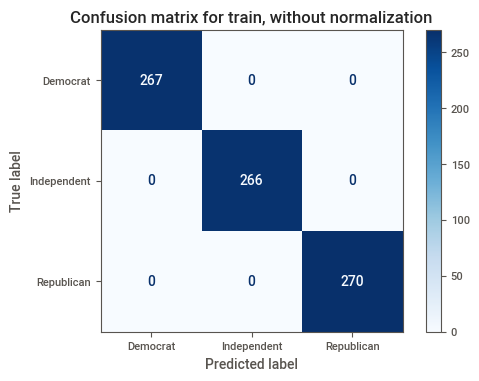

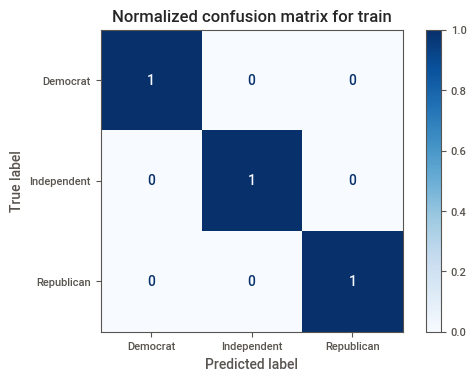

In [725]:
# confusion matrix for training data
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, without normalization
[[26 27 16]
 [30 27 14]
 [24 19 18]]
Normalized confusion matrix for test
[[0.37681159 0.39130435 0.23188406]
 [0.42253521 0.38028169 0.1971831 ]
 [0.39344262 0.31147541 0.29508197]]


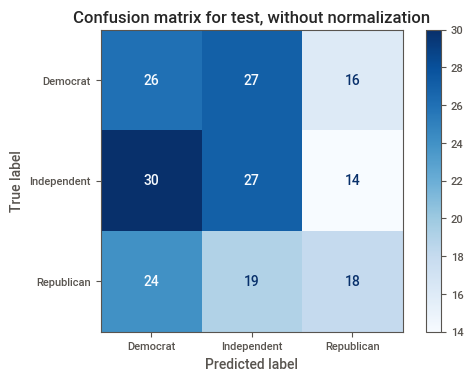

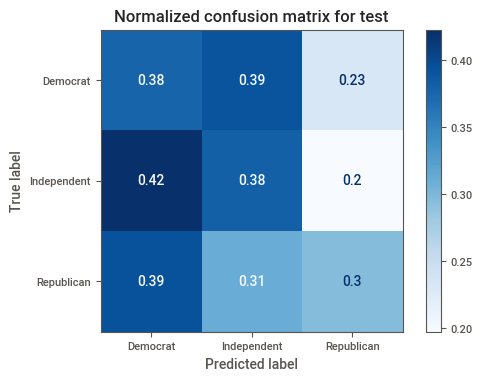

In [726]:
# confusion matrix on test data
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion Matrix displays the number of correct and incorrect predictions made by the model.



## Optional Hacker Extra tasks
### Model 3 - HistGradientBoosting Classifier

Imported required libraries

In [727]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

# Need the following to encode our target variable
from sklearn.preprocessing import OrdinalEncoder

We will use the same training and test dataset as used in Logistic and RandomForest regression models. 

In [728]:
# Create lists of columns by variable type
target_col = ['PoliticalParty']
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

Transformed data by using StandardScaler and OrdinalEncoder. Created pipeline with transformed data and trained the model using the training dataset. Tested the model on the test dataset. Created Confusion Matrix to display the predictions made by the model.

In [729]:
numeric_transformer_hgbc = StandardScaler()
categorical_transformer_hgbc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
target_transformer_hgbc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

preprocessor_hgbc = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_hgbc, categorical_cols),
        ('num', numeric_transformer_hgbc, numeric_cols)],
        remainder='passthrough')

In [730]:
categorical_cols_idx = [_ for _ in range(len(categorical_cols))]
clf_hgbc = Pipeline(steps=[('preprocessor', preprocessor_hgbc),
                      ('classifier', HistGradientBoostingClassifier(categorical_features=categorical_cols_idx))])

In [731]:
clf_hgbc.fit(X_train, y_train)
print(f"hgbc training score: {clf_hgbc.score(X_train, y_train):.3f}")
print(f"hgbc test score: {clf_hgbc.score(X_test, y_test):.3f}")

hgbc training score: 1.000
hgbc test score: 0.358


[[267   0   0]
 [  0 266   0]
 [  0   0 270]]
Confusion matrix for HGBC_training


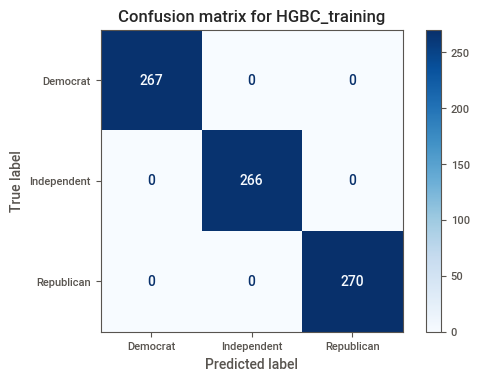

In [732]:
title = ("Confusion matrix for HGBC_training")
class_names = clf_hgbc['classifier'].classes_

disp = plot_confusion_matrix(clf_hgbc, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

[[24 26 19]
 [26 29 16]
 [20 22 19]]
Confusion matrix for HGBC_test


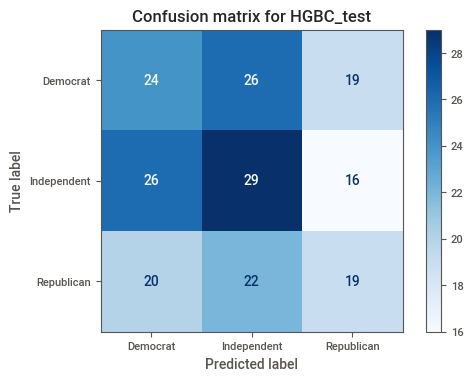

In [670]:
title = ("Confusion matrix for HGBC_test")
class_names = clf_hgbc['classifier'].classes_

disp = plot_confusion_matrix(clf_hgbc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

HistGradientBoosting Classifier also performs similar to Random Forest with excellent training score and less efficient at test scores. This model also has overfitting concern like with the Random Forest. This model performs slightly better in test scores when compared to Random forest, but very minimal.

Summary - On comparing all the models based on their training an test score , we can conclude that logistic regression with ridge regularization has performed better. This model was more efficient in predicting the target variable

### Predicting `Filed FY2017`

Will now create the same set of models using the dataset but will treat FY2017 as the target variable and will include PoliticalParty as an input variable.

In [671]:
tax_df_filed = tax_df[['Married','CollegGrads','Cars','Filed_2016','Filed_2015','AgeGroup','HHIGroup','HHDLGroup','PoliticalParty','Filed_2017']]

- Divided tax_df_new into two separate dataframes X_new and y_new (input variables and Target) , to use in the models.

- Created data list which will capture names of numerical and categorical variables

- Partitioned the data to create test and training data sets 

In [672]:
X_filed = tax_df_filed.iloc[:, 0:9]
y_filed = tax_df_filed.iloc[:, 9]

In [741]:
categorical_cols_filed = X_filed.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols_filed = X_filed.select_dtypes(include=['number']).columns.tolist()

In [674]:
train_X, test_X, train_y, test_y = train_test_split(X_filed, y_filed, test_size=0.2, random_state=21)

Model Creation 

#### Logistic Regression 

Created LogisticRegression models using all the three flavours of regularization

- ##### Ridge Regularization

We will use the same models that we had created earlier using LogisticRegressionCV function. Will fit and the models using the new training and test data

Created preprocessor object, pipeline object and then fitted the training data on the model. Added ConfusionMatrix for both training and testdataset

In [675]:
preprocessor_filed = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_filed),
        ('cat', categorical_transformer, categorical_cols_filed)])

In [676]:
clf_model_cv = LogisticRegressionCV(penalty='l2', Cs=[ 0.1, 1, 10], solver='saga', max_iter=500)

clf_l2_cv_filed = Pipeline(steps=[('preprocessor', preprocessor_filed),
                      ('classifier', clf_model_cv)])

clf_l2_cv_filed.fit(train_X, train_y)

print(f"Training score-clf_l2_cv_filed: {clf_l2_cv_filed.score(train_X, train_y):.3f}")
print(f"Test score-clf_l2_cv_filed: {clf_l2_cv_filed.score(test_X, test_y):.3f}")

Training score-clf_l2_cv_filed: 0.582
Test score-clf_l2_cv_filed: 0.587


[[207 184]
 [152 260]]
Confusion matrix on Training dataset for LogisticRegression - Ridge Regularization


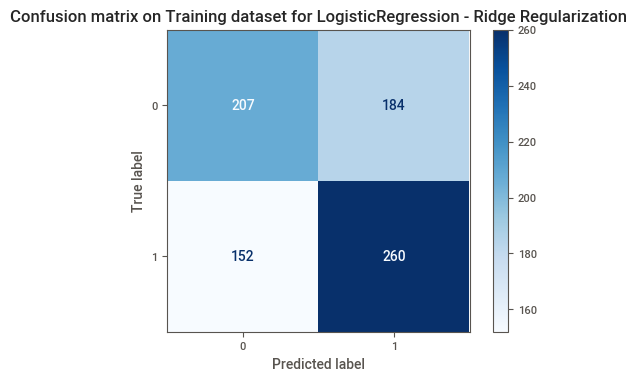

In [677]:
## Confusion Matrix
title = ("Confusion matrix on Training dataset for LogisticRegression - Ridge Regularization")
class_names = clf_l2_cv_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_l2_cv_filed, train_X, train_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

[[57 46]
 [37 61]]
Confusion matrix on Test dataset for LogisticRegression - Ridge Regularization


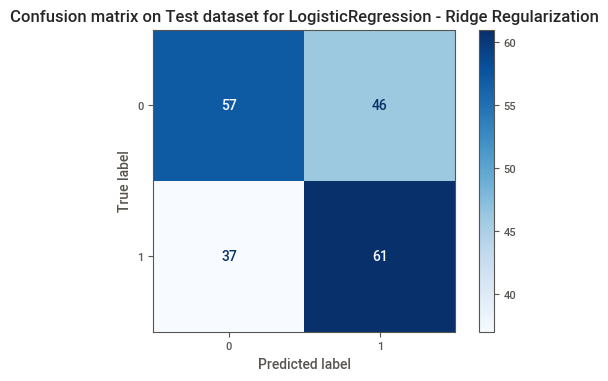

In [678]:
## Confusion Matrix
title = ("Confusion matrix on Test dataset for LogisticRegression - Ridge Regularization")
class_names = clf_l2_cv_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_l2_cv_filed, test_X, test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

##### Lasso Regularization

In [679]:
clf_model_l1 = LogisticRegressionCV(penalty='l1', Cs=[ 0.1, 1, 10], solver='saga', max_iter=500)

clf_l1_filed = Pipeline(steps=[('preprocessor', preprocessor_filed),
                      ('classifier', clf_model_l1)])

clf_l1_filed.fit(train_X, train_y)

print(f"Training score-clf_l1: {clf_l1_filed.score(train_X, train_y):.3f}")
print(f"Test score-clf_l1: {clf_l1_filed.score(train_X, train_y):.3f}")

Training score-clf_l1: 0.580
Test score-clf_l1: 0.580


[[206 185]
 [152 260]]
Confusion matrix on Training dataset for LogisticRegression - lasso Regularization


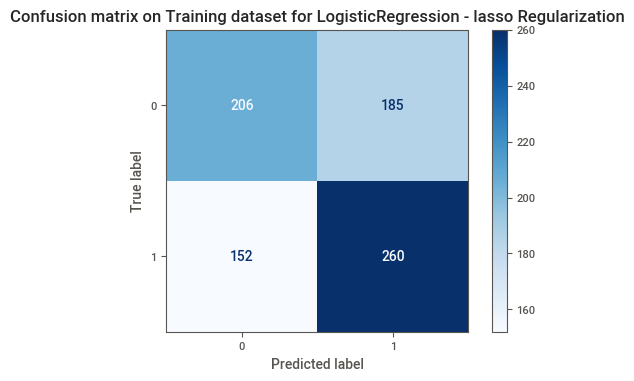

In [680]:
## Confusion Matrix
title = ("Confusion matrix on Training dataset for LogisticRegression - lasso Regularization")
class_names = clf_l1_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_l1_filed, train_X, train_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

[[57 46]
 [37 61]]
Confusion matrix on Test dataset for LogisticRegression - Ridge Regularization


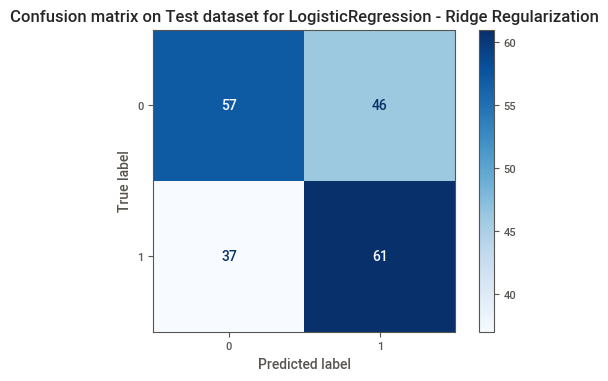

In [681]:
## Confusion Matrix
title = ("Confusion matrix on Test dataset for LogisticRegression - Ridge Regularization")
class_names = clf_l2_cv_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_l2_cv_filed, test_X, test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

##### Elasticnet Regularization

In [735]:
clf_model_en = LogisticRegressionCV(penalty='elasticnet', Cs=[ 0.1, 1, 10] ,solver='saga', max_iter=500, l1_ratios=[0.0, 0.25, 0.5, 0.75, 1.0])

clf_en_filed = Pipeline(steps=[('preprocessor', preprocessor_filed),
                      ('classifier', clf_model_en)])

clf_en_filed.fit(train_X, train_y)

print(f"Training score-clf_en: {clf_en_filed.score(train_X, train_y):.3f}")
print(f"Test score-clf_en: {clf_en_filed.score(train_X, train_y):.3f}")

Training score-clf_en: 0.590
Test score-clf_en: 0.590


[[190 201]
 [128 284]]
Confusion matrix on Training dataset for LogisticRegression - elasticnet Regularization


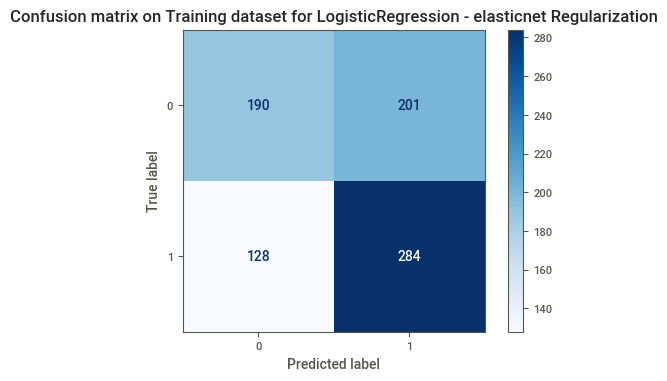

In [736]:
## Confusion Matrix
title = ("Confusion matrix on Training dataset for LogisticRegression - elasticnet Regularization")
class_names = clf_en_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_en_filed, train_X, train_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

[[50 53]
 [36 62]]
Confusion matrix on Test dataset for LogisticRegression - elasticnet Regularization


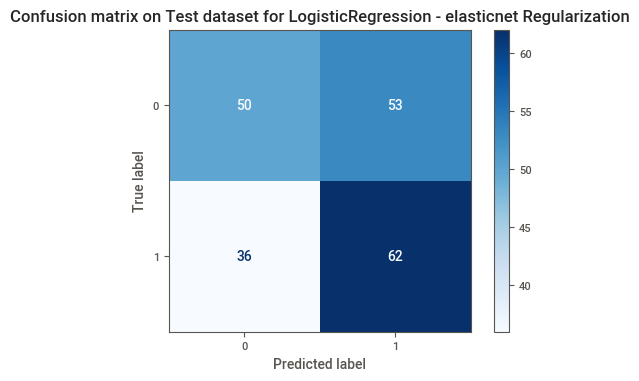

In [737]:
## Confusion Matrix
title = ("Confusion matrix on Test dataset for LogisticRegression - elasticnet Regularization")
class_names = clf_en_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_en_filed, test_X, test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

#### RandomForest Model

Created RandomForest model to predict the target variable

In [738]:
clf_rf_filed = Pipeline(steps=[('preprocessor', preprocessor_filed),
                      ('classifier', RandomForestClassifier(oob_score=True, random_state=0))])

clf_rf_filed.fit(train_X, train_y)

print(f"Training score: {clf_rf_filed.score(train_X, train_y):.3f}")
print(f"Test score: {clf_rf_filed.score(test_X, test_y):.3f}")

Training score: 1.000
Test score: 0.532


[[391   0]
 [  0 412]]
Confusion matrix on Training dataset for RandomForest


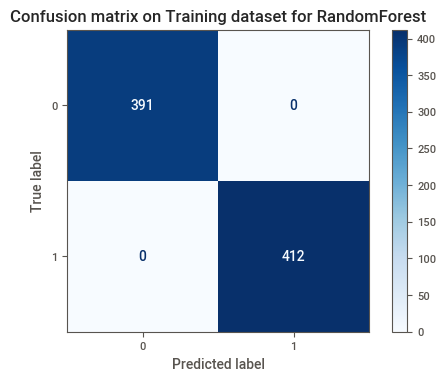

In [686]:
## Confusion Matrix
title = ("Confusion matrix on Training dataset for RandomForest")
class_names = clf_rf_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_rf_filed, train_X, train_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

[[57 46]
 [48 50]]
Confusion matrix on Test dataset for RandomForest


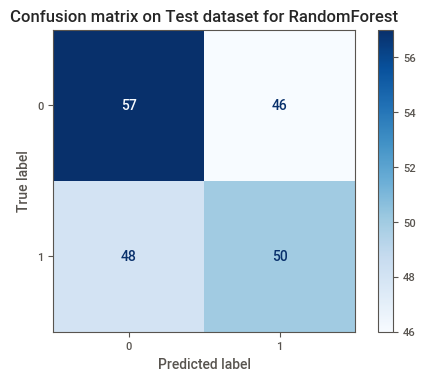

In [687]:
## Confusion Matrix
title = ("Confusion matrix on Test dataset for RandomForest")
class_names = clf_rf_filed['classifier'].classes_

disp = plot_confusion_matrix(clf_rf_filed, test_X, test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title(title)
print(disp.confusion_matrix)
print(title)
plt.show()

### Summary
From all the models we have created (Logistic & RandomForest) to predict Filed_2017 we see that all models were able to predict better when compared with the same models which predicted PoliticalParty. Reason for the improved performance is the number of factors available in the target variable. The probability of predicting the output increases with decrease in the number of factors in the target variable. Issue of overfitting the data continued in the RandomForest model when predicting FY2017 also.